In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import yaml

In [4]:
#load Accelerator data
#load Accelerator data



d = yaml.safe_load(open('/home/sanjeev/GPT/simulation_2023-08-09_14-26-39/dump.yaml'))
data = pd.DataFrame(d['data'])
data.index = list(map(int, data.index))
data.sort_index(inplace=True)
len(data)


data['bunch_length'] = data['bunch_length']*1e-12


KeyboardInterrupt: 

In [ ]:
data.tail()

,Sol_var,Gun_phase,Emit_X,Emit_y,Emit_mean,Energy,SigX,SigY,Bunch_length,Num_Particles,xopt_runtime,xopt_error
xopt_index,,,,,,,,,,,,
1975,0.244238,270.001025,0.000004,0.000003,0.000004,0.124978,0.269164,0.006339,1.521231e-12,9975,71.480727,False
1983,0.223621,270.023405,0.000005,0.000005,0.000005,0.124978,0.254051,0.246225,1.509485e-12,9974,68.871096,False
1994,0.236666,270.005989,0.000004,0.000004,0.000004,0.124978,0.251162,0.031029,1.516114e-12,9979,68.528303,False
1995,0.213896,270.001097,0.000006,0.000005,0.000006,0.124978,0.266012,0.255133,1.506308e-12,9975,67.791706,False
1998,0.196940,270.008793,0.000006,0.000006,0.000006,0.124977,0.298209,0.266910,1.502584e-12,9979,71.076091,False


Epoch 1 - Training loss: 0.6993439892927805 - Validation loss: 0.6094475835561752
Epoch 2 - Training loss: 0.6623155574003855 - Validation loss: 0.5670309960842133
Epoch 3 - Training loss: 0.622210701306661 - Validation loss: 0.5009526386857033
Epoch 4 - Training loss: 0.5525343343615532 - Validation loss: 0.4082614853978157
Epoch 5 - Training loss: 0.48574967682361603 - Validation loss: 0.36793792992830276
Epoch 6 - Training loss: 0.4657501106460889 - Validation loss: 0.35460951179265976
Epoch 7 - Training loss: 0.44848232219616574 - Validation loss: 0.3402799442410469
Epoch 8 - Training loss: 0.4351665476957957 - Validation loss: 0.32926104217767715
Epoch 9 - Training loss: 0.42158524692058563 - Validation loss: 0.32001473009586334
Epoch 10 - Training loss: 0.41421110183000565 - Validation loss: 0.31801311671733856
Epoch 11 - Training loss: 0.40848471224308014 - Validation loss: 0.31173448264598846
Epoch 12 - Training loss: 0.40141674627860385 - Validation loss: 0.2988138422369957
Ep

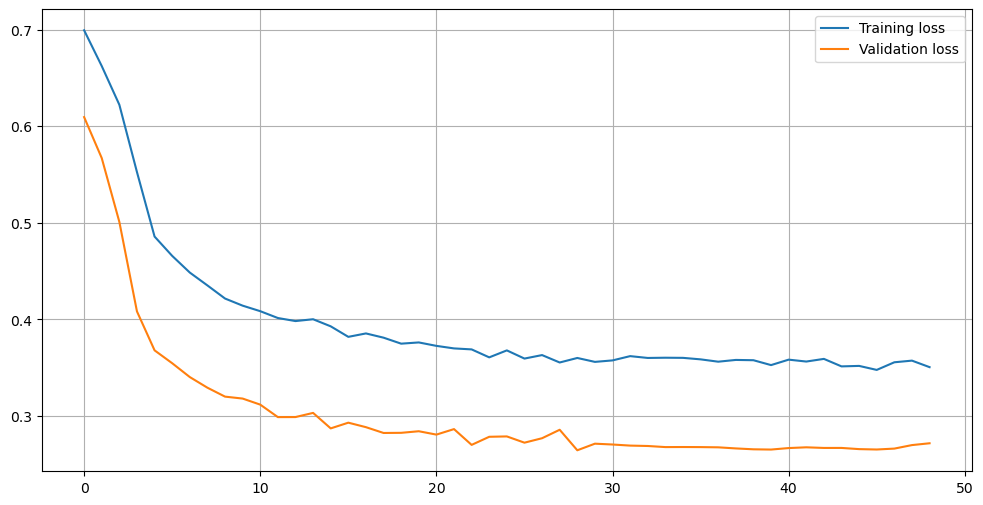

In [ ]:
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from math import sqrt
#load Accelerator data




# Define the features and targets
features = ['Sol_var','Gun_phase']
targets = ['Emit_X', 'Emit_y', 'Emit_mean', 'Energy', 'SigX', 'SigY', 'Bunch_length', 'Num_Particles']

# Create separate scalers for features and targets
scaler_features = StandardScaler()
scaler_targets = StandardScaler()

# Fit the scalers and transform the data
data[features] = scaler_features.fit_transform(data[features])
data[targets] = scaler_targets.fit_transform(data[targets])


# Split the data into training, testing, and validation sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42) 

# Create PyTorch Datasets and DataLoaders
batch_size = 100
train_dataset = TensorDataset(torch.tensor(train_data[features].values).float(), torch.tensor(train_data[targets].values).float())
val_dataset = TensorDataset(torch.tensor(val_data[features].values).float(), torch.tensor(val_data[targets].values).float())
test_dataset = TensorDataset(torch.tensor(test_data[features].values).float(), torch.tensor(test_data[targets].values).float())

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the network architecture
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(hidden_size, hidden_size)  # additional hidden layer
        self.dropout3 = nn.Dropout(0.4)  # additional dropout layer
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))  # pass through additional hidden layer
        x = self.dropout3(x)  # pass through additional dropout layer
        x = self.fc4(x)
        return x

# Initialize the network and define the loss function and the optimizer
net = Net(input_size=len(features), hidden_size=50, output_size=len(targets))
criterion = nn.L1Loss()  # Changed this line to use MAE
optimizer = optim.Adam(net.parameters(), lr=0.001)
# Add a scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
# Training loop with early stopping
num_epochs = 1000
patience = 20
early_stopping_counter = 0
best_loss = float('inf')

train_loss = []
val_loss = []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0], data[1]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        
    # Call the learning rate scheduler at the end of the epoch
    scheduler.step()


    # validation part
    net.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data[0], data[1]
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

    running_loss /= len(train_dataloader)
    validation_loss /= len(val_dataloader)
    print(f"Epoch {epoch+1} - Training loss: {running_loss} - Validation loss: {validation_loss}")
    
    train_loss.append(running_loss)
    val_loss.append(validation_loss)
    
    # early stopping
    if validation_loss < best_loss:
        best_loss = validation_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        
    if early_stopping_counter >= patience:
        print('Early stopping...')
        break

# Define the model evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    mse_loss = 0.0
    mae_loss = 0.0
    n_samples = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            mse_loss += criterion(outputs, labels).item() * inputs.shape[0]
            mae_loss += torch.nn.L1Loss()(outputs, labels).item() * inputs.shape[0]
            n_samples += inputs.shape[0]
    mse_loss /= n_samples
    rmse_loss = sqrt(mse_loss)
    mae_loss /= n_samples
    return mse_loss, rmse_loss, mae_loss

# Evaluate the model on the test data
mse_loss, rmse_loss, mae_loss = evaluate_model(net, test_dataloader)
print(f'MSE Loss: {mse_loss:.6f}, RMSE Loss: {rmse_loss:.6f}, MAE Loss: {mae_loss:.6f}')

# After training, we'll plot the training and validation loss
plt.figure(figsize=(12,6))
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid(True)
plt.show()


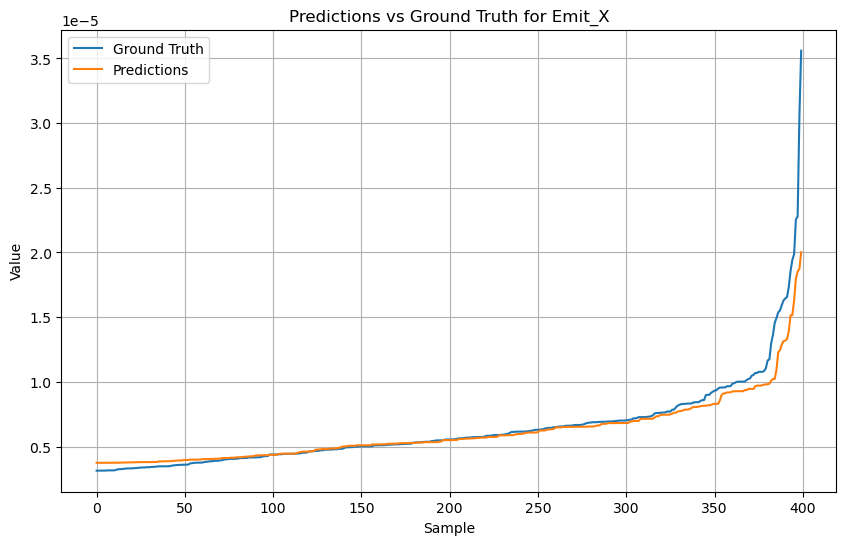

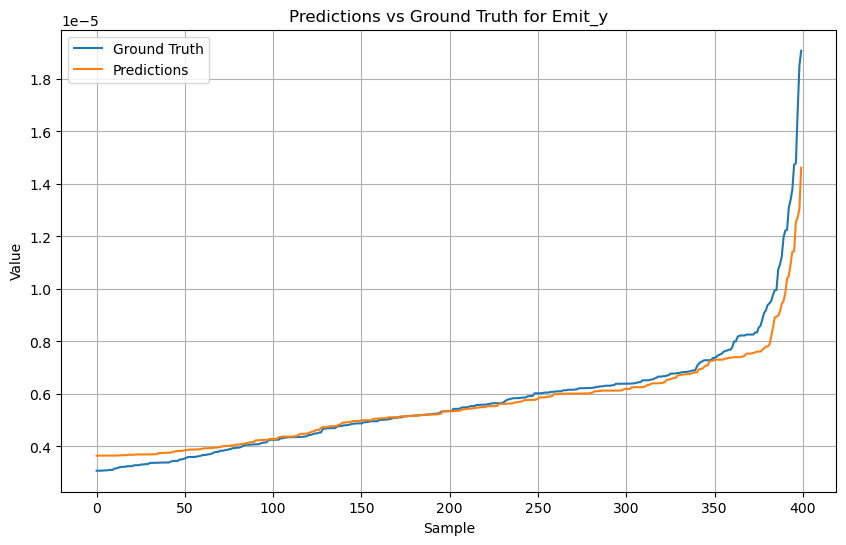

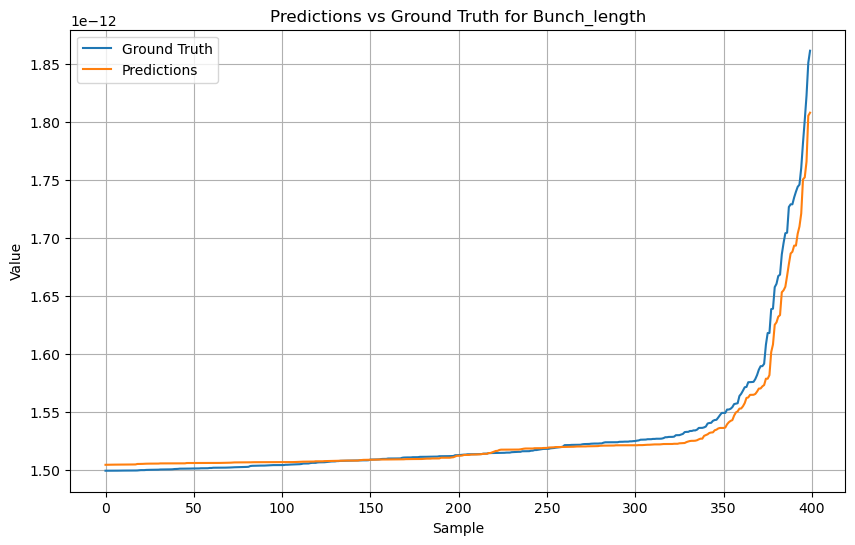

In [ ]:
import numpy as np

# Generate predictions for test set
net.eval()
with torch.no_grad():
    predictions = net(torch.tensor(test_data[features].values).float())

# Convert the tensor to a numpy array
predictions = predictions.numpy()
predictions = scaler_targets.inverse_transform(predictions)
actual_data = scaler_targets.inverse_transform(test_data[targets].values)

# Create a dataframe of predictions
pred_df = pd.DataFrame(predictions, columns=targets, index=test_data.index)
test_data = pd.DataFrame(actual_data, columns=targets, index=test_data.index)

# Select targets to plot
targets_to_plot = ['Emit_X', 'Emit_y', 'Bunch_length']

for target in targets_to_plot:
    # Sort the ground truth and predictions by the magnitude of the predictions
    sorted_test_data = test_data.sort_values(by=target)
    sorted_pred_df = pred_df.sort_values(by=target)

    # Plot the ground truth and predictions
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_test_data[target].values, label='Ground Truth')
    plt.plot(sorted_pred_df[target].values, label='Predictions')
    plt.title(f"Predictions vs Ground Truth for {target}")
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


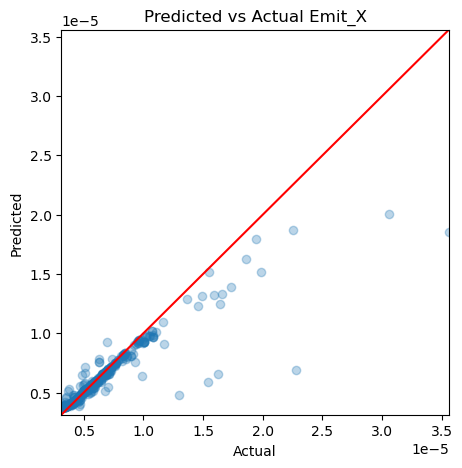

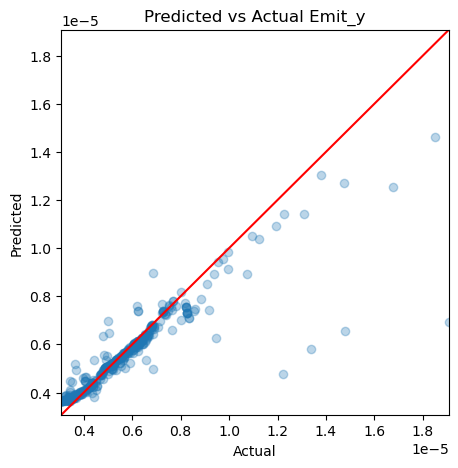

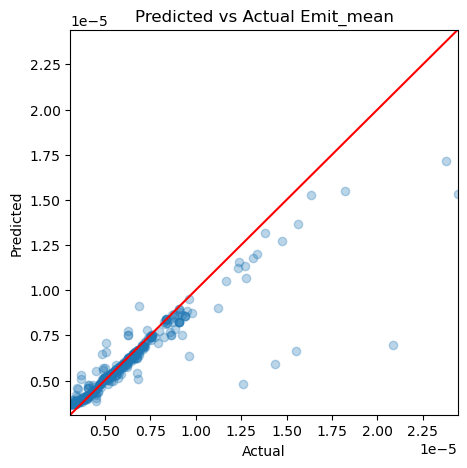

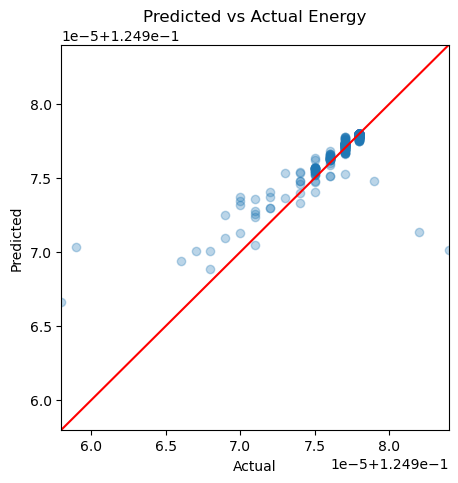

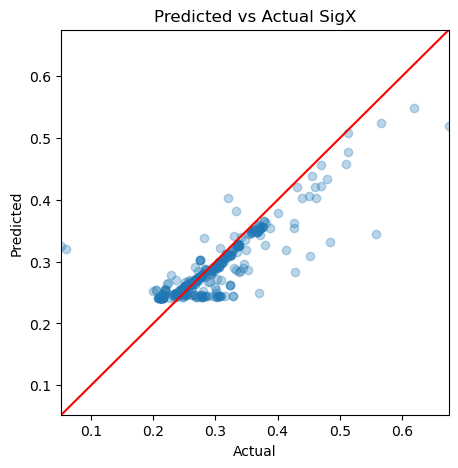

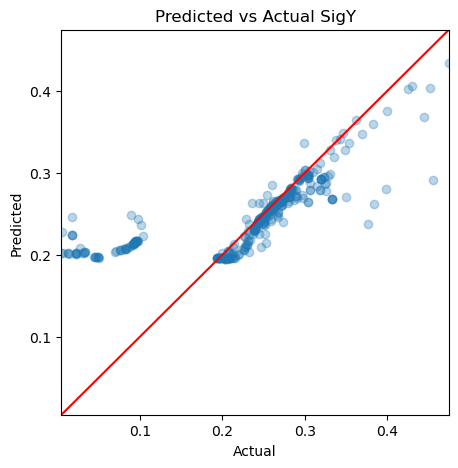

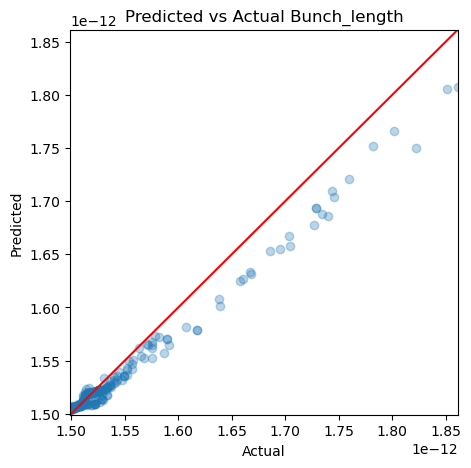

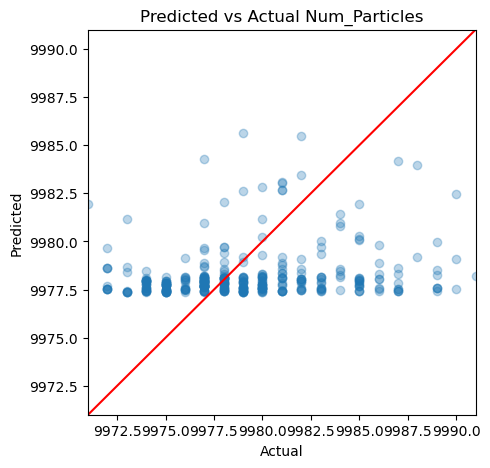

In [ ]:
# calculate predictions
net.eval()
predictions = []
actuals = []
with torch.no_grad():
    for data, target in test_dataloader:
        output = net(data)
        predictions.append(output.numpy())
        actuals.append(target.numpy())
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# inverse transform the data
# Assume `predictions_scaled` is a numpy array containing model predictions in the scaled form
predictions = scaler_targets.inverse_transform(predictions)
actuals = scaler_targets.inverse_transform(actuals)

# create scatter plots
for i, target in enumerate(targets):
    plt.figure(figsize=(5, 5))
    plt.scatter(actuals[:, i], predictions[:, i], alpha=0.3)
    plt.title(f'Predicted vs Actual {target}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    max_val = max(actuals[:, i].max(), predictions[:, i].max())
    min_val = min(actuals[:, i].min(), predictions[:, i].min())
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.plot([min_val, max_val], [min_val, max_val], color='red')
    plt.show()


/home/sanjeev/miniconda3/envs/ML/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/sanjeev/miniconda3/envs/ML/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


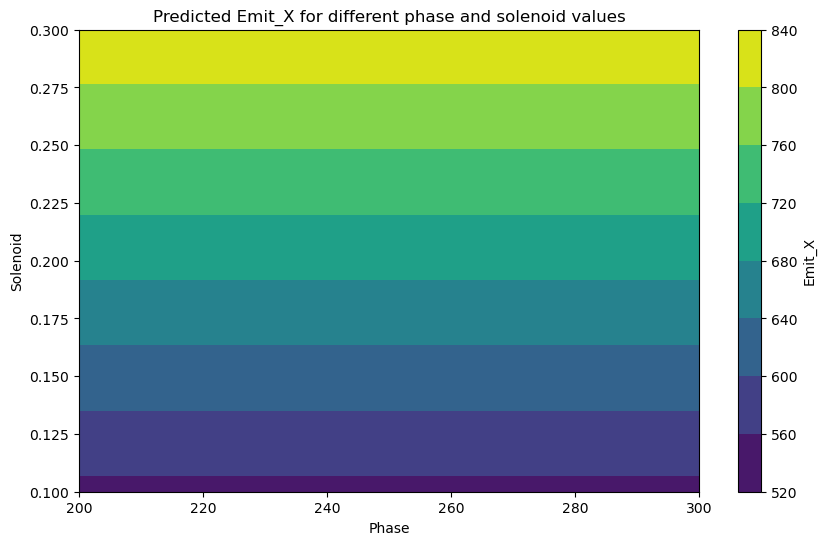

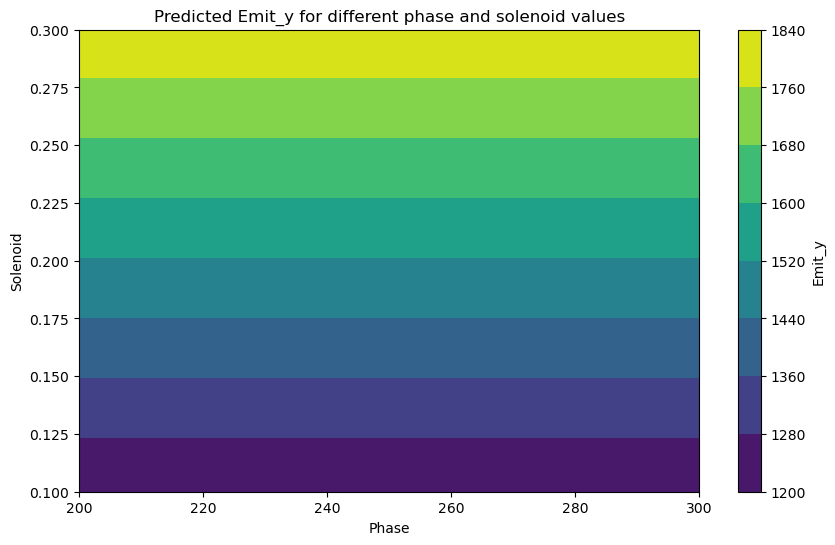

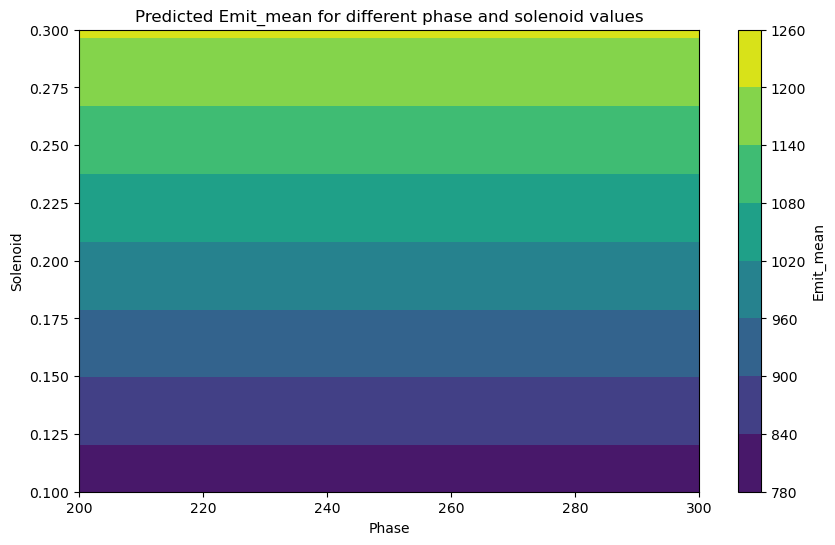

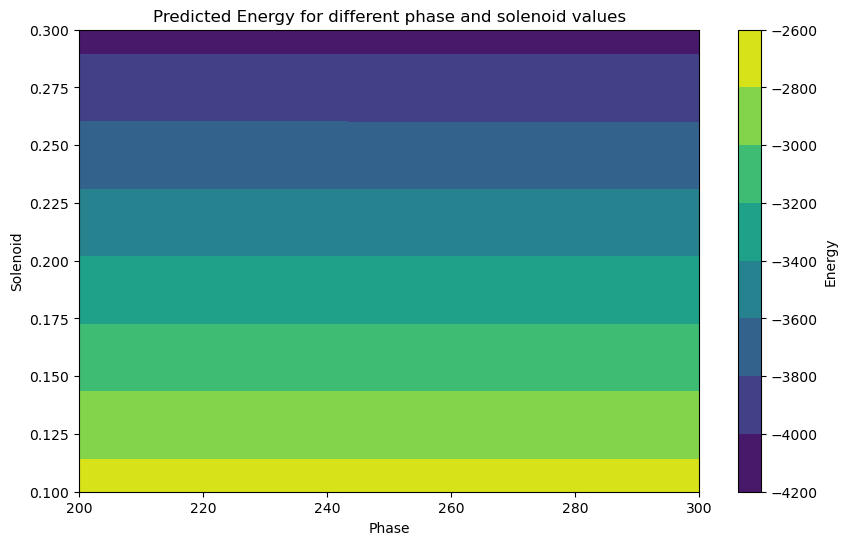

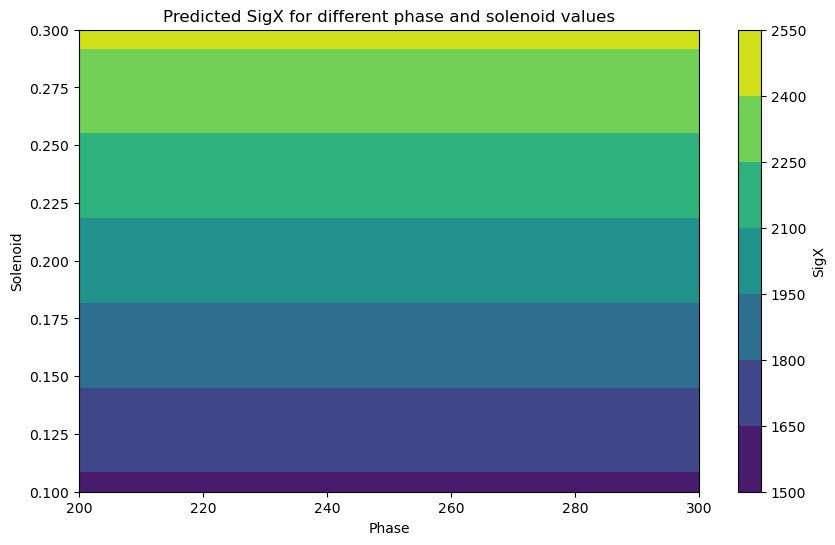

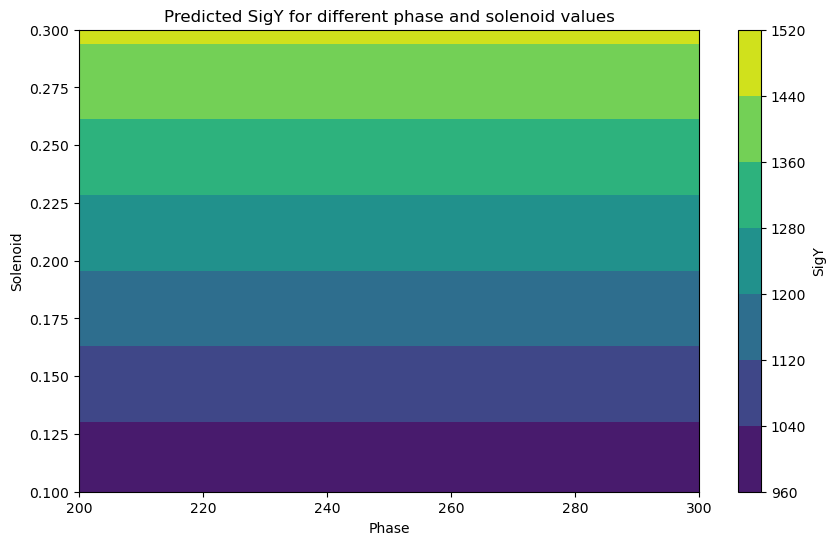

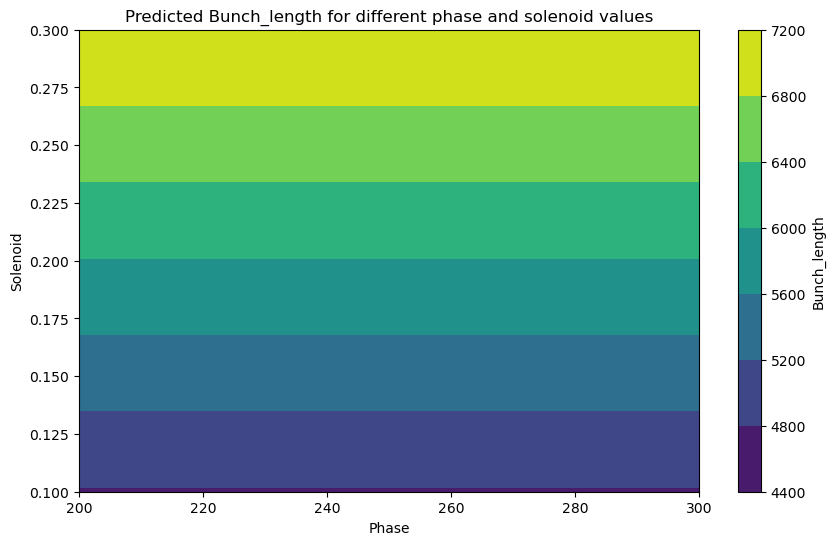

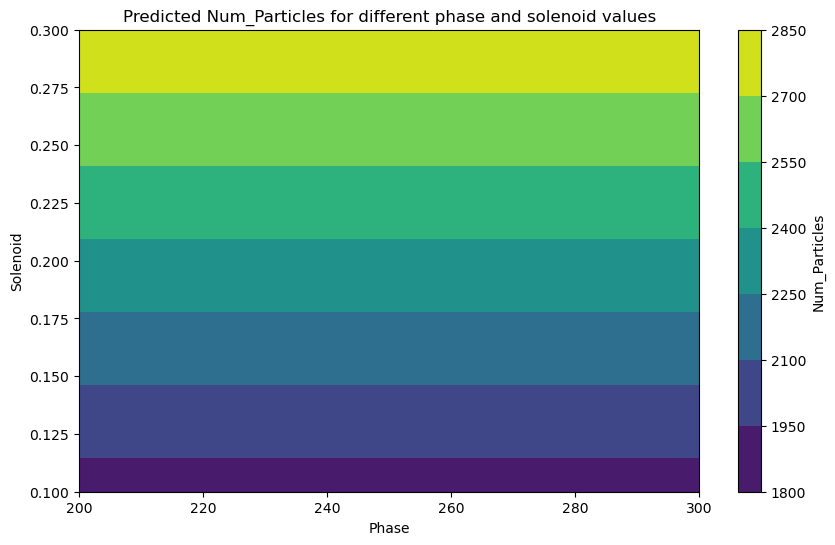

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a grid of points
gun_phase_values = np.linspace(200, 300, 100)
sol_var_values = np.linspace(0.1, 0.3, 100)

# Transform variable range using the scaler for features
gun_phase_values_scaled = scaler_features.transform(np.array([[200, 0.2],[300, 0.2]]))[:,0]
sol_var_values_scaled = scaler_features.transform(np.array([[280, 0.1],[280, 0.3]]))[:,1]

gun_phase_values_scaled = np.linspace(gun_phase_values_scaled[0], gun_phase_values_scaled[1], 100)
sol_var_values_scaled = np.linspace(sol_var_values_scaled[0], sol_var_values_scaled[1], 100)

# Create an empty array to hold the predictions
predictions = np.zeros((100, 100, len(targets)))

# Predict the outputs for each point in the grid
for i, gun_phase in enumerate(gun_phase_values_scaled):
    for j, sol_var in enumerate(sol_var_values_scaled):
        input_features = torch.tensor([gun_phase, sol_var]).float().unsqueeze(0)
        prediction = net(input_features)
        predictions[i, j, :] = prediction.detach().numpy()

# Plot the predicted outputs
for target_idx, target in enumerate(targets):
    plt.figure(figsize=(10, 6))
    plt.contourf(gun_phase_values, sol_var_values, predictions[:, :, target_idx])
    plt.title(f"Predicted {target} for different phase and solenoid values")
    plt.xlabel('Phase')
    plt.ylabel('Solenoid')
    plt.colorbar(label=target)
    plt.show()
